Import Dependences

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

Generating Data - Sine Wave 

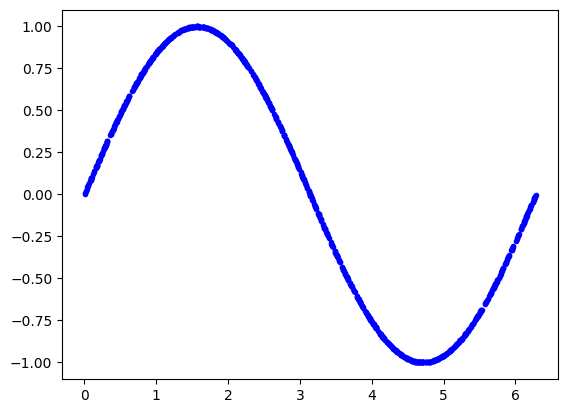

In [2]:
SAMPLES = 1000
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)
x_values = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES)
np.random.shuffle(x_values)
y_values = np.sin(x_values)
plt.plot(x_values, y_values, 'b.')
plt.show()

Adding Noise to the Database

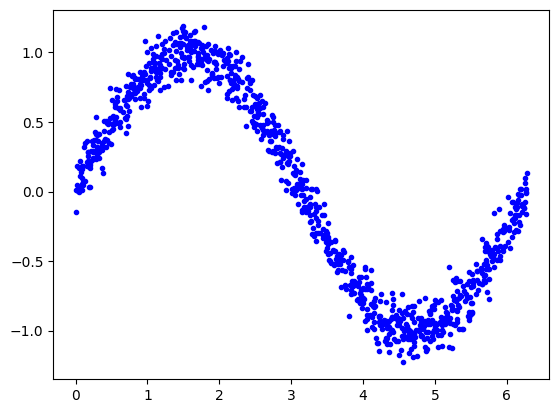

In [3]:
y_values += 0.1*np.random.randn(*y_values.shape)
plt.plot(x_values, y_values, 'b.')
plt.show()

Splitting the Data

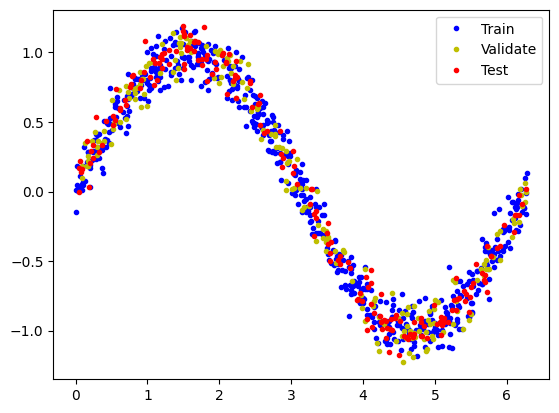

In [4]:
TRAIN_SPLIT = int(0.6*SAMPLES)
TEST_SPLIT = int(0.2*SAMPLES+TRAIN_SPLIT)
x_train, x_validate, x_test = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_validate, y_test = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])
assert(x_train.size + x_validate.size + x_test.size) == SAMPLES
plt.plot(x_train, y_train, 'b.', label='Train')
plt.plot(x_validate, y_validate, 'y.', label='Validate')
plt.plot(x_test, y_test, 'r.', label='Test')
plt.legend()
plt.show()

Defining a Basic Model

In [5]:
from keras import layers
model_1 = tf.keras.Sequential()
model_1.add(layers.Dense(16, activation='relu', input_shape=(1,)))
model_1.add(layers.Dense(1))
model_1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [6]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                32        
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


Training Our Model


In [7]:
history_1 = model_1.fit(x_train, y_train, epochs=1000, batch_size=16,
                        validation_data=(x_validate, y_validate))

Epoch 1/1000
38/38 [==============================] - 1s 11ms/step - loss: 2.9313 - mae: 1.3686 - val_loss: 1.9073 - val_mae: 1.1546
Epoch 2/1000
38/38 [==============================] - 0s 3ms/step - loss: 1.3511 - mae: 1.0015 - val_loss: 0.9476 - val_mae: 0.8809
Epoch 3/1000
38/38 [==============================] - 0s 6ms/step - loss: 0.7312 - mae: 0.7771 - val_loss: 0.6407 - val_mae: 0.7221
Epoch 4/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.5446 - mae: 0.6537 - val_loss: 0.5356 - val_mae: 0.6427
Epoch 5/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.4788 - mae: 0.6026 - val_loss: 0.4828 - val_mae: 0.6065
Epoch 6/1000
38/38 [==============================] - 0s 6ms/step - loss: 0.4332 - mae: 0.5723 - val_loss: 0.4406 - val_mae: 0.5735
Epoch 7/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.3945 - mae: 0.5430 - val_loss: 0.4039 - val_mae: 0.5549
Epoch 8/1000
38/38 [==============================] - 0s 4ms/step - loss: 0

Graphing the History

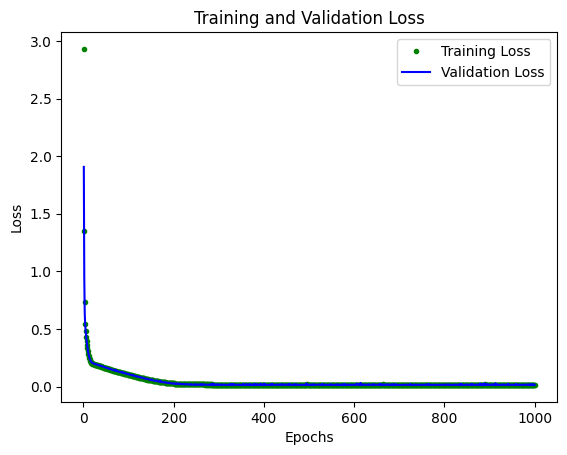

In [8]:
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'g.', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

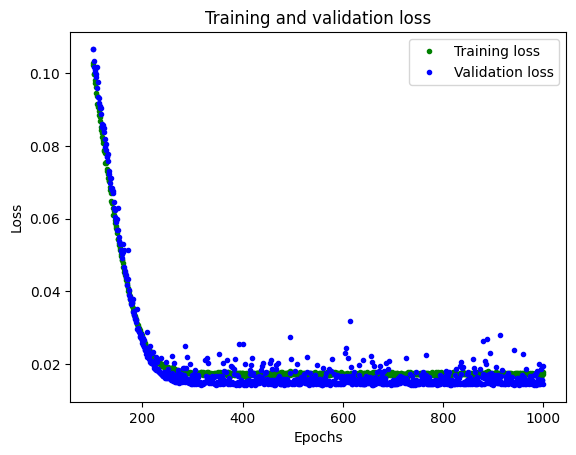

In [9]:
SKIP = 100
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

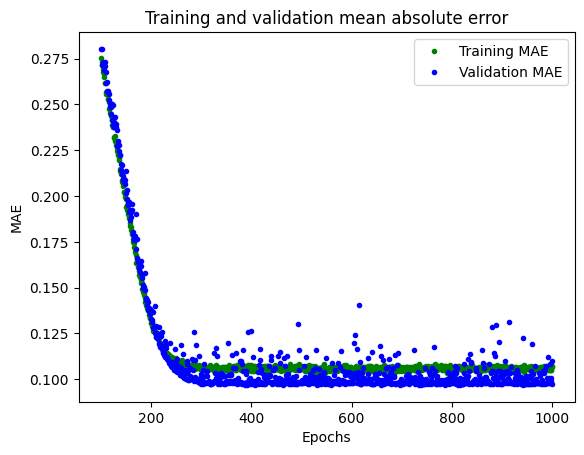

In [10]:
mae = history_1.history['mae']
val_mae = history_1.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

19/19 [==============================] - 0s 2ms/step


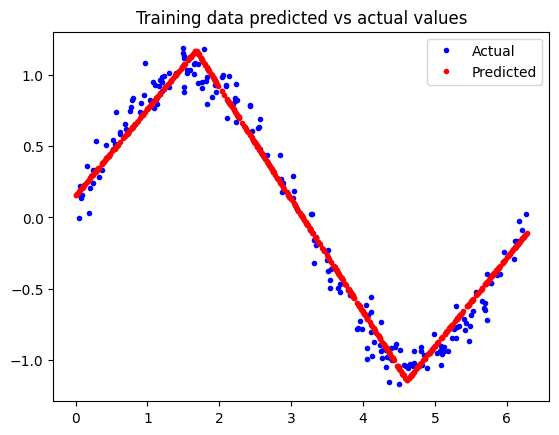

In [11]:
predictions = model_1.predict(x_train)
plt.clf()
plt.title('Training data predicted vs actual values')
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_train, predictions, 'r.', label='Predicted')
plt.legend()
plt.show()

Improving Our Model


In [12]:
model_2 = tf.keras.Sequential()
model_2.add(layers.Dense(16, activation='relu', input_shape=(1,)))
model_2.add(layers.Dense(16, activation='relu'))
model_2.add(layers.Dense(1))
model_2.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [13]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                32        
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [14]:
history_2 = model_2.fit(x_train, y_train, epochs=600, batch_size=16,
 validation_data=(x_validate, y_validate))

Epoch 1/600
38/38 [==============================] - 1s 10ms/step - loss: 0.6881 - mae: 0.6801 - val_loss: 0.3793 - val_mae: 0.5313
Epoch 2/600
38/38 [==============================] - 0s 7ms/step - loss: 0.3375 - mae: 0.5051 - val_loss: 0.3368 - val_mae: 0.4935
Epoch 3/600
38/38 [==============================] - 0s 5ms/step - loss: 0.2916 - mae: 0.4697 - val_loss: 0.2861 - val_mae: 0.4616
Epoch 4/600
38/38 [==============================] - 0s 7ms/step - loss: 0.2538 - mae: 0.4393 - val_loss: 0.2502 - val_mae: 0.4310
Epoch 5/600
38/38 [==============================] - 0s 5ms/step - loss: 0.2246 - mae: 0.4156 - val_loss: 0.2179 - val_mae: 0.4031
Epoch 6/600
38/38 [==============================] - 0s 4ms/step - loss: 0.2007 - mae: 0.3923 - val_loss: 0.2049 - val_mae: 0.3831
Epoch 7/600
38/38 [==============================] - 0s 5ms/step - loss: 0.1874 - mae: 0.3767 - val_loss: 0.1932 - val_mae: 0.3786
Epoch 8/600
38/38 [==============================] - 0s 6ms/step - loss: 0.1773 - 

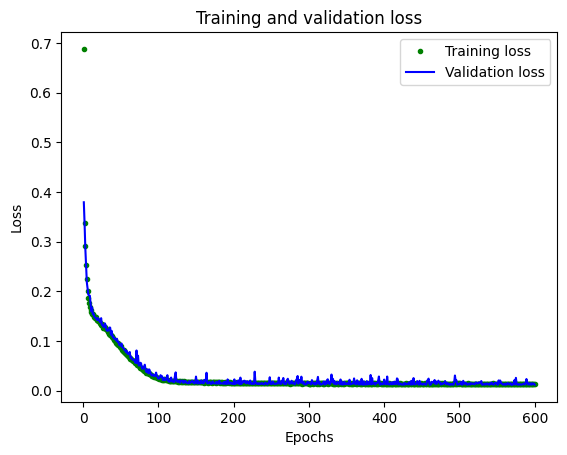

In [15]:
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

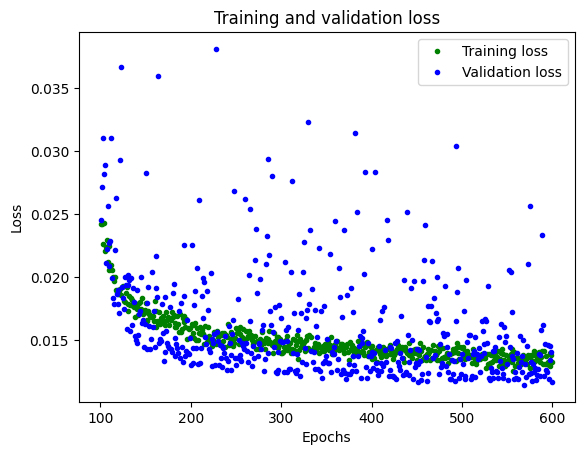

In [16]:
SKIP = 100
plt.clf()
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

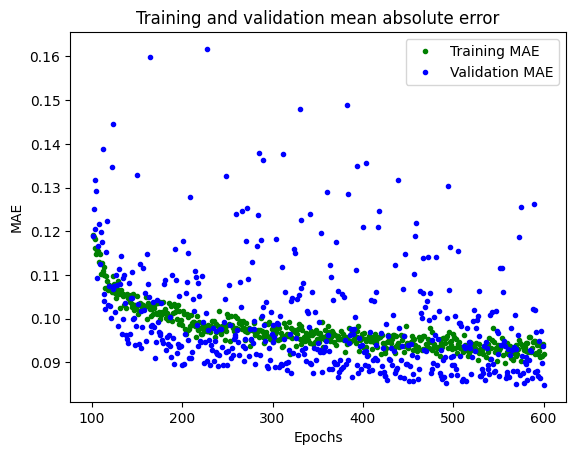

In [17]:
plt.clf()
mae = history_2.history['mae']
val_mae = history_2.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

Testing

7/7 [==============================] - 0s 2ms/step


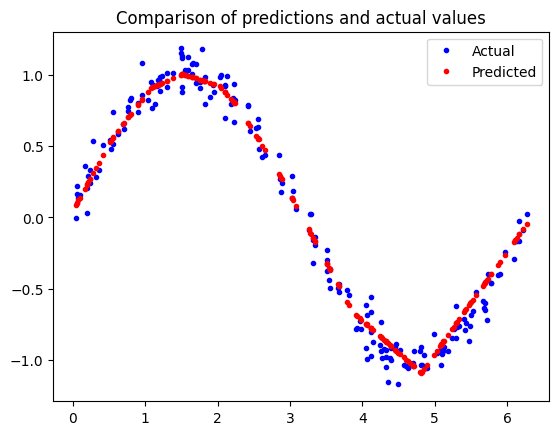

In [18]:
loss = model_2.evaluate(x_test, y_test)
predictions = model_2.predict(x_test)
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_test, predictions, 'r.', label='Predicted')
plt.legend()
plt.show()

Converting the Model for TensorFlow Lite

In [19]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
tflite_model = converter.convert()
open("sine_model.tflite", "wb").write(tflite_model)
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
def representative_dataset_generator():
 for value in x_test:
  yield [np.array(value, dtype=np.float32, ndmin=2)]
converter.representative_dataset = representative_dataset_generator
tflite_model = converter.convert()
open("sine_model_quantized.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\fcost\AppData\Local\Temp\tmpfhew3876\assets


INFO:tensorflow:Assets written to: C:\Users\fcost\AppData\Local\Temp\tmpfhew3876\assets


INFO:tensorflow:Assets written to: C:\Users\fcost\AppData\Local\Temp\tmpfh9q3lzd\assets


INFO:tensorflow:Assets written to: C:\Users\fcost\AppData\Local\Temp\tmpfh9q3lzd\assets
c:\Users\fcost\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\lite\python\convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


3040

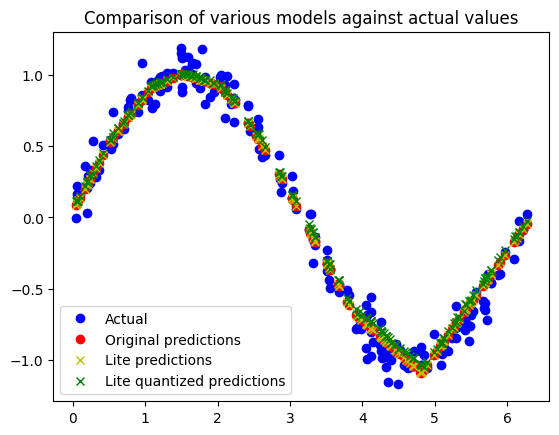

In [20]:
sine_model = tf.lite.Interpreter('sine_model.tflite')
sine_model_quantized = tf.lite.Interpreter('sine_model_quantized.tflite')
sine_model.allocate_tensors()
sine_model_quantized.allocate_tensors()
sine_model_input_index = sine_model.get_input_details()[0]["index"]
sine_model_output_index = sine_model.get_output_details()[0]["index"]
sine_model_quantized_input_index = sine_model_quantized.get_input_details()[0]["index"]
sine_model_quantized_output_index = sine_model_quantized.get_output_details()[0]["index"]
sine_model_predictions = []
sine_model_quantized_predictions = []
for x_value in x_test:
  x_value_tensor = tf.convert_to_tensor([[x_value]], dtype=np.float32)
  sine_model.set_tensor(sine_model_input_index, x_value_tensor)
  sine_model.invoke()
  sine_model_predictions.append(
      sine_model.get_tensor(sine_model_output_index)[0])
  sine_model_quantized.set_tensor(sine_model_quantized_input_index, x_value_tensor)
  sine_model_quantized.invoke()
  sine_model_quantized_predictions.append(
      sine_model_quantized.get_tensor(sine_model_quantized_output_index)[0])
plt.clf()
plt.title('Comparison of various models against actual values')
plt.plot(x_test, y_test, 'bo', label='Actual')
plt.plot(x_test, predictions, 'ro', label='Original predictions')
plt.plot(x_test, sine_model_predictions, 'yx', label='Lite predictions')
plt.plot(x_test, sine_model_quantized_predictions, 'gx', label='Lite quantized predictions')
plt.legend()
plt.show()

In [21]:
import os
basic_model_size = os.path.getsize("sine_model.tflite")
print("Basic model is %d bytes" % basic_model_size)
quantized_model_size = os.path.getsize("sine_model_quantized.tflite")
print("Quantized model is %d bytes" % quantized_model_size)
difference = basic_model_size - quantized_model_size
print("Difference is %d bytes" % difference)

Basic model is 3192 bytes
Quantized model is 3040 bytes
Difference is 152 bytes


Convert the Model to .cc File

In [22]:
!apt-get update && apt-get -qq install xxd

'apt-get' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


In [23]:
!xxd -i sine_model_quantized.tflite > sine_model_quantized.cc
!cat sine_model_quantized.cc

'xxd' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.
'cat' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


In [24]:
!xxd -i sine_model_quantized.tflite > sine_model_quantized.h
!cat sine_model_quantized.h

'xxd' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.
'cat' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


In [25]:
!xxd -i sine_model_quantized.tflite > sine_model_quantized.cpp
!cat sine_model_quantized.cpp

'xxd' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.
'cat' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


In [32]:
print(sine_model_input_index)

0
